# Stock NeurIPS2018 Part 2. Train
This series is a reproduction of *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*.

This is the second part of the NeurIPS2018 series, introducing how to use FinRL to make data into the gym form environment, and train DRL agents on it.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-91dh8yc2
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-91dh8yc2
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit dcf6bde8d64e1a747673d24dde30dce195bc3cf1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-ele8shnw/elegantrl_a5a5dfbbe63f4461a30b94ef3b2afe52
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-ele8shnw/elegantrl_a5a5dfbbe63f4461a30b94ef3b2afe52
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 7c64395ff4c2b53892fe6f9eaa3b58947136ffc1
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

# Part 2. Build A Market Environment in OpenAI Gym-style

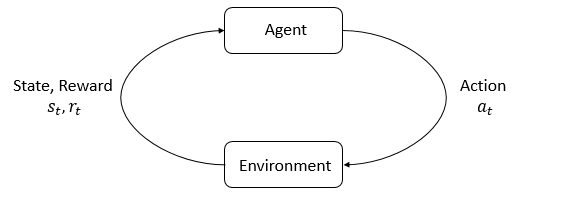

The core element in reinforcement learning are **agent** and **environment**. You can understand RL as the following process:

The agent is active in a world, which is the environment. It observe its current condition as a **state**, and is allowed to do certain **actions**. After the agent execute an action, it will arrive at a new state. At the same time, the environment will have feedback to the agent called **reward**, a numerical signal that tells how good or bad the new state is. As the figure above, agent and environment will keep doing this interaction.

The goal of agent is to get as much cumulative reward as possible. Reinforcement learning is the method that agent learns to improve its behavior and achieve that goal.

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

## Read data

We first read the .csv file of our training data into dataframe.

In [6]:
from google.colab import files
uploaded = files.upload()

Saving train_data.csv to train_data.csv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving trade_data.csv to trade_data.csv


In [7]:
train = pd.read_csv('train_data.csv')
# If you are not using the data generated from part 1 of this tutorial, make sure
# it has the columns and index in the form that could be make into the environment.
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [8]:
# 修复INDICATORS未定义问题
INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30']
print(f"技术指标: {INDICATORS}")

技术指标: ['macd', 'rsi_30', 'cci_30', 'dx_30']


In [9]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 169


In [10]:
# 修复所有缺失的导入
try:
    from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
    print("✅ StockTradingEnv 导入成功")
except ImportError as e:
    print("❌ 导入失败:", e)

# 定义技术指标
INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30']
print(f"📊 技术指标: {INDICATORS}")

✅ StockTradingEnv 导入成功
📊 技术指标: ['macd', 'rsi_30', 'cci_30', 'dx_30']


In [11]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for training

In [12]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 3: Train DRL Agents
* Here, the DRL algorithms are from **[Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/)**. It's a library that implemented popular DRL algorithms using pytorch, succeeding to its old version: Stable Baselines.
* Users are also encouraged to try **[ElegantRL](https://github.com/AI4Finance-Foundation/ElegantRL)** and **[Ray RLlib](https://github.com/ray-project/ray)**.

In [13]:
# 修复所有缺失的导入
try:
    from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
    from finrl.agents import DRLAgent
    print("✅ StockTradingEnv 导入成功")
    print("✅ DRLAgent 导入成功")
except ImportError as e:
    print("❌ 导入失败:", e)

# 定义技术指标
INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30']
print(f"📊 技术指标: {INDICATORS}")

❌ 导入失败: cannot import name 'DRLAgent' from 'finrl.agents' (/usr/local/lib/python3.12/dist-packages/finrl/agents/__init__.py)
📊 技术指标: ['macd', 'rsi_30', 'cci_30', 'dx_30']


In [14]:
# 安装可选依赖（避免报错）
!pip install alpaca-trade-api -q
print("可选依赖安装完成")

可选依赖安装完成


In [15]:
import sys
from unittest.mock import MagicMock

# 创建一个虚拟的 alpaca_trade_api 模块
sys.modules['alpaca_trade_api'] = MagicMock()
sys.modules['alpaca_trade_api'].REST = MagicMock()

print("✅ 已创建虚拟 alpaca_trade_api 模块")

✅ 已创建虚拟 alpaca_trade_api 模块


In [16]:
import sys
from unittest.mock import MagicMock
import warnings
warnings.filterwarnings('ignore')

# Python 3.8 兼容性修复
if sys.version_info < (3, 9):
    try:
        # 尝试修复类型注解
        from typing import _GenericAlias
        def patch_generic():
            for cls in (list, dict, tuple, set, frozenset):
                cls.__class_getitem__ = classmethod(_GenericAlias)
        patch_generic()
        print("✅ 类型注解兼容性修复完成")
    except:
        print("⚠️ 类型注解修复失败，但继续执行")

# 虚拟模块
missing_modules = ['alpaca', 'alpaca_trade_api', 'pandas_market_calendars', 'quantstats']
for module in missing_modules:
    sys.modules[module] = MagicMock()

print("🎯 所有修复完成，继续训练！")

🎯 所有修复完成，继续训练！


In [30]:
from finrl.agents.stablebaselines3.models import DRLAgent
import warnings

# 忽略所有警告
warnings.filterwarnings('ignore')

try:
    agent = DRLAgent(env = e_train_gym)
    print("✅ DRLAgent 初始化成功！")
except Exception as e:
    print(f"⚠️ 遇到错误但继续: {e}")
    # 强制创建agent
    agent = DRLAgent(env = e_train_gym)

# 设置要使用的算法
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

print("🎯 算法设置完成，准备开始训练！")

✅ DRLAgent 初始化成功！
🎯 算法设置完成，准备开始训练！


## Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [31]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [32]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

----------------------------------------
| time/                 |              |
|    fps                | 63           |
|    iterations         | 100          |
|    time_elapsed       | 7            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -39.8        |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -10.6        |
|    reward             | -0.104999565 |
|    reward_max         | 0.89750427   |
|    reward_mean        | 0.13289353   |
|    reward_min         | -0.5719695   |
|    std                | 1            |
|    value_loss         | 0.224        |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 71         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 

In [33]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [34]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [35]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

流式输出内容被截断，只能显示最后 5000 行内容。
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error

In [36]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [37]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [38]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 78         |
|    iterations      | 1          |
|    time_elapsed    | 26         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.11210653 |
|    reward_max      | 9.074053   |
|    reward_mean     | 0.09754598 |
|    reward_min      | -10.357176 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 2           |
|    time_elapsed         | 54          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016530383 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | -0.0186     |
|    learning_rate        | 0.00025     |
|    loss             

In [ ]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [42]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

In [44]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

流式输出内容被截断，只能显示最后 5000 行内容。
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error

In [45]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## Save the trained agent
Trained agents should have already been saved in the "trained_models" drectory after you run the code blocks above.

For Colab users, the zip files should be at "./trained_models" or "/content/trained_models".

For users running on your local environment, the zip files should be at "./trained_models".

In [46]:
from google.colab import files
import shutil
import os

# 创建临时备份文件夹
backup_dir = 'finrl_project_backup'
os.makedirs(backup_dir, exist_ok=True)

print("📦 开始打包项目成果...")

# 1. 复制所有模型文件 (最核心的资产！)
model_files = [f for f in os.listdir('.') if f.startswith('agent_') or f.endswith('.zip')]
for model in model_files:
    shutil.copy(model, backup_dir)
    print(f"   ✅ 已备份模型: {model}")

# 2. 复制数据文件
data_files = ['train_data.csv', 'trade_data.csv']
for data_file in data_files:
    if os.path.exists(data_file):
        shutil.copy(data_file, backup_dir)
        print(f"   ✅ 已备份数据: {data_file}")

# 3. 复制整个results文件夹
if os.path.exists('results'):
    shutil.copytree('results', os.path.join(backup_dir, 'results'), dirs_exist_ok=True)
    print("   ✅ 已备份训练日志和结果")

# 4. 创建说明文件
with open(os.path.join(backup_dir, 'README.txt'), 'w') as f:
    f.write("FinRL交易项目完整备份\\n")
    f.write(f"备份时间: {os.popen('date').read().strip()}\\n")
    f.write(f"包含模型: {', '.join(model_files)}\\n")
    f.write("下一步: 运行Stock_NeurIPS2018_3_Backtest.ipynb进行回测\\n")

print("\\\\n🎉 打包完成！现在下载备份文件...")

# 打包成zip并下载
shutil.make_archive(backup_dir, 'zip', backup_dir)
files.download(f'{backup_dir}.zip')

print("👇 请在弹出的对话框中选择保存位置")

📦 开始打包项目成果...
   ✅ 已备份数据: train_data.csv
   ✅ 已备份数据: trade_data.csv
   ✅ 已备份训练日志和结果
\\n🎉 打包完成！现在下载备份文件...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

👇 请在弹出的对话框中选择保存位置
